In [1]:
import os
from scipy.io import loadmat

src_path = "C:/Users/h1006/Documents/Research/Sun/Code/Matlab_output/201211_Suisei/EE/"
src_name_list = os.listdir(src_path)
src_name_list.sort()

# dataset names
label1 = "tau"
tau_name_list = []
tau_mat_all = []

label2 = "theta"
theta_name_list = []
theta_mat_all = []

for elm in src_name_list:
    if label1 in elm:
        tau_name_list.append(elm)
    if label2 in elm:
        theta_name_list.append(elm)

for elm in tau_name_list:
    tau_mat_all.append(loadmat(src_path+elm))

for elm in theta_name_list:
    theta_mat_all.append(loadmat(src_path+elm))

print("len(tau_mat_all)", len(tau_mat_all))
print("tau_mat_all[0].keys()", tau_mat_all[0].keys())
print("len(theta_mat_all)", len(theta_mat_all))
print("theta_mat_all[0].keys()", theta_mat_all[0].keys())

len(tau_mat_all) 100
tau_mat_all[0].keys() dict_keys(['__header__', '__version__', '__globals__', 'params', 'v'])
len(theta_mat_all) 54
theta_mat_all[0].keys() dict_keys(['__header__', '__version__', '__globals__', 'params', 'v'])


In [2]:
# Check data

name_list = tau_name_list
mat_all = tau_mat_all
file_id = 10

# From Matlab code 201210

# % Pehlevan model + SLS
# %params = [m L k1 k2 c mu_bf Ff t_max w_NE w_EN w_EE w_tE w_ES w_En theta_E tauE theta_N tauN theta_t taut theta_S];
# %save(['EE_Response-w_ES-' num2str(w_ES) '-theta_S-' num2str(theta_S) '.mat'], 'v', 'params');

# % GDL model + SLS
# params = [m L k1 k2 c mu_bf Ff t_max w_ENd w_NE w_EN w_tE w_ES theta_E tauE theta_N tauN theta_t taut theta_S];
# save(['EI_Response-w_ES-' num2str(w_ES) '-theta_S-' num2str(theta_S) '.mat'], 'v', 'params');

param_id_EE = ["m", "L", "k1", "k2", "c", "mu_bf", "Ff", "t_max", "w_NE", "w_EN", "w_EE", "w_tE", "w_ES", "w_En",
               "theta_E", "tauE", "theta_N", "tauN", "theta_t", "taut", "theta_S"]
param_id_EI = ["m", "L", "k1", "k2", "c", "mu_bf", "Ff", "t_max", "w_ENd", "w_NE", "w_EN", "w_tE", "w_ES",
               "theta_E", "tauE", "theta_N", "tauN", "theta_t", "taut", "theta_S"]

mat_file = mat_all[file_id]
print(name_list[file_id])
for i in range(len(param_id_EE)):
    print("{0}:{1}".format(param_id_EE[i], mat_file["params"][0][i]))
print("data shape:", mat_file["v"].shape)

EE_Response-tauE-15-tauN-10.mat
m:0.1
L:0.41
k1:3.5
k2:4.6
c:190000.0
mu_bf:10.0
Ff:0.05
t_max:4.1
w_NE:0.6
w_EN:-2.0
w_EE:1.0
w_tE:1.0
w_ES:1.95
w_En:0.6
theta_E:0.6
tauE:15.0
theta_N:0.6
tauN:10.0
theta_t:0.2
taut:150.0
theta_S:0.8
data shape: (500, 68)


In [3]:
# Analyze mat files

import numpy as np

src_mat_all = tau_mat_all

# Create param dataset

params_all = []
for file_id in range(len(src_mat_all)):
    params_all.append(src_mat_all[file_id]["params"][0])

# Create data of boundary position

# Constants
L_init = 0.41
index_position = [22 - i*2 for i in range(12)] # adjust indexing

y_all = []

for file_id in range(len(src_mat_all)):
    y = []
    for i in range(len(index_position)):
        y.append(src_mat_all[file_id]["v"][:,index_position[i]] + L_init*i)
    y = np.array(y).T
    y_all.append(y)
y_all = np.array(y_all)

print("position at t=0:{}".format(y_all[0][0]))
print("y_all.shape:", y_all.shape)

# Calculate kinematics from boundary position data

import peakutils

# constants
sec_per_frame = 0.01  # 0.03333 for larva measurement

initial_disp_all = []
disp_rel_all = []
disp_abs_all = []
seg_len_all = []
body_len_all = []

for file_id in range(len(y_all)):

    dat = y_all[file_id]   # frame, boundary
    boundary_num = len(dat[0])
    
    # initial position
    initial_disp = []
    for bd in range(boundary_num):
        v0 = dat[0,0]   # dat[0,0,:] for vector
        v1 = dat[0,bd]  # dat[0,bd,:] for vector
        initial_disp.append(v1-v0)  # use np.linalg.norm for vector
    initial_disp_all.append(initial_disp)

    # displacement_rel
    disp_rel = []
    for bd in range(boundary_num):
        disp_seg = []
        for frame in range(len(dat)):
            t = frame * sec_per_frame
            v0 = dat[0,bd]   # dat[0,bd,:] for vector
            v1 = dat[frame,bd]   # dat[frame,bd,:] for vector
            disp_seg.append([t, v1-v0])  # use np.linalg.norm for vector
        disp_rel.append(disp_seg)
    disp_rel = np.array(disp_rel)
    disp_rel_all.append(disp_rel)

    # displacement_abs
    disp_abs = []
    for bd in range(boundary_num):
        disp_abs0 = []
        for frame in range(len(disp_rel[0])):
            t = disp_rel[bd,frame,0]
            disp_abs00 = disp_rel[bd,frame,1] + initial_disp[bd]
            disp_abs0.append([t, disp_abs00])
        disp_abs.append(disp_abs0)
    disp_abs = np.array(disp_abs)
    disp_abs_all.append(disp_abs)

    # segment length
    seg_len = []
    for seg in range(boundary_num-1):
        seg_len0 = []
        for frame in range(len(dat)):
            t = frame * sec_per_frame
            v0 = dat[frame,seg]   # dat[frame,seg,:] for vector
            v1 = dat[frame,seg+1]   # dat[frame,seg+1,:] for vector
            seg_len0.append([t, v1-v0])  # use np.linalg.norm for vector
        seg_len.append(seg_len0)
    seg_len = np.array(seg_len)
    seg_len_all.append(seg_len)

    # body length
    body_len = []
    for frame in range(len(dat)):
        t = frame * sec_per_frame
        v0 = dat[frame,0] # posterior end, dat[frame,0,:] for vector
        v1 = dat[frame,boundary_num-1] # anterior end, dat[frame,boundary_num-1,:] for vector
        body_len.append([t, v1-v0])  # use np.linalg.norm for vector
    body_len_all.append(np.array(body_len))

    # segment length
    seg_len_range_all = []
    seg_len_peaks_all = []
    for file_id in range(len(seg_len_all)):
        
        # find peaks
        seg_len_peaks0 = []
        for seg in range(len(seg_len_all[file_id])):
            dat = seg_len_all[file_id][seg][:,1]
            
            # removing NaN
            dat_noNaN = dat[np.logical_not(np.isnan(dat))]
            
            
            peaks_id_p = peakutils.indexes(dat_noNaN, thres=0.2, min_dist=100)
            peaks_id_n = peakutils.indexes(-dat_noNaN, thres=0.2, min_dist=100)
            seg_len_peaks0.append([peaks_id_p, peaks_id_n])
        #seg_len_peaks0 = np.array(seg_len_peaks0)
        seg_len_peaks_all.append(seg_len_peaks0)
        
        # measure length
        seg_len_range0 = []
        for seg in range(len(seg_len_all[file_id])):
            dat_src = seg_len_all[file_id][seg]
            dat_peaks = seg_len_peaks0[seg]

            dst_p = [dat_src[dat_peaks[0],0], dat_src[dat_peaks[0],1]]
            dst_n = [dat_src[dat_peaks[1],0], dat_src[dat_peaks[1],1]]
            seg_len_range0.append([dst_p, dst_n])

            #plt.plot(dat_src[:,0], dat_src[:,1])
            #plt.plot(dat_src[dat_peaks[0],0], dat_src[dat_peaks[0],1], 'go')
            #plt.plot(dat_src[dat_peaks[1],0], dat_src[dat_peaks[1],1], 'mo')
            #plt.show()
            #plt.savefig(src_path + "img/201126_11_points_segment_length_{0}_seg{1}.png".format(src_name[file_id], seg))
            #plt.close()
        #seg_len_range0 = np.array(seg_len_range0)
        seg_len_range_all.append(seg_len_range0)
    
print("len(initial_disp_all)(file_number):", len(initial_disp_all))
print("len(initial_disp_all[0]) (seg number):", len(initial_disp_all[0]))

disp_rel_all = np.array(disp_rel_all, dtype="float64")
disp_abs_all = np.array(disp_abs_all, dtype="float64")
seg_len_all = np.array(seg_len_all, dtype="float64")
body_len_all = np.array(body_len_all, dtype="float64")


print("disp_rel_all.shape:", disp_rel_all.shape)
print("disp_abs_all.shape:", disp_abs_all.shape)
print("seg_len_all.shape:", seg_len_all.shape)
print("body_len_all.shape:", body_len_all.shape)

print("len(seg_len_range_all):", len(seg_len_range_all))
print("len(seg_len_range_all[0]):", len(seg_len_range_all[0]))
print("len(seg_len_peaks_all):", len(seg_len_peaks_all))
print("len(seg_len_peaks_all[0]):", len(seg_len_peaks_all[0]))

position at t=0:[0.   0.41 0.82 1.23 1.64 2.05 2.46 2.87 3.28 3.69 4.1  4.51]
y_all.shape: (100, 500, 12)
len(initial_disp_all)(file_number): 100
len(initial_disp_all[0]) (seg number): 12
disp_rel_all.shape: (100, 12, 500, 2)
disp_abs_all.shape: (100, 12, 500, 2)
seg_len_all.shape: (100, 11, 500, 2)
body_len_all.shape: (100, 500, 2)
len(seg_len_range_all): 100
len(seg_len_range_all[0]): 11
len(seg_len_peaks_all): 100
len(seg_len_peaks_all[0]): 11


In [4]:
# Plot y_all [file_id]

import matplotlib.pyplot as plt
import numpy as np

img_path = "C:/Users/h1006/Documents/Research/Sun/Code/Matlab_output/201211_Suisei/img/"

sec_per_frame = 0.01
total_frame = 500
t = np.arange(0,total_frame)*sec_per_frame

for file_id in range(len(y_all)):

    boundary_num = len(y_all[file_id][0])

    plt.figure(figsize=(12,6))
    for i in range(boundary_num):
        plt.plot(t, y_all[file_id][:,i])
    plt.title(name_list[file_id])
    plt.savefig(img_path + name_list[file_id] + ".png")
    plt.close()

# Parameter extraction

In [5]:
# Stride length

import numpy as np
import peakutils
from scipy import signal
from scipy.signal import argrelmax
from sklearn.linear_model import LinearRegression


xmin = 0
xmax = 40
bins = 800
width = (xmax-xmin)/bins

stride_all = []

for file_id in range(len(disp_abs_all)):
    stride_seg = []
    for seg in range(len(disp_abs_all[0])):
        stride_seg0 = []
        hist_dat = np.histogram(disp_abs_all[file_id][seg,:,1], bins=bins, range=(xmin,xmax))
        #peaks = hist_dat[1][argrelmax(hist_dat[0], order=4)]
        peaks_id = peakutils.indexes(hist_dat[0], thres=0.2, min_dist=5)
        peaks_id = np.sort(peaks_id)
        peaks = hist_dat[1][peaks_id]
        for peak_id in range(len(peaks)):
            dat0 = disp_abs_all[file_id][seg]
            disp_peak = [dat0[i,1] for i in range(len(dat0)) 
                         if dat0[i,1] > peaks[peak_id] and dat0[i,1] < peaks[peak_id] + width]
            time_peak = [dat0[i,0] for i in range(len(dat0)) 
                         if dat0[i,1] > peaks[peak_id] and dat0[i,1] < peaks[peak_id] + width]
            disp_peak_med = np.median(disp_peak)
            time_peak_med = np.median(time_peak)
            stride_seg0.append([time_peak_med, disp_peak_med])
        stride_seg.append(np.array(stride_seg0))

    stride_all.append(stride_seg)
    #plt.figure()
    #for seg in range(11):
    #    plt.plot(disp_abs_all[file_id][seg,:,0], disp_abs_all[file_id][seg,:,1])
    #    plt.plot(stride_all[file_id][seg][:,0], stride_all[file_id][seg][:,1], 'o')

    #plt.title("Displacement of file {0}".format(src_name_list[file_id]))
    #plt.xlabel("Time (sec)")
    #plt.ylabel("Displacement (mm)")
    #plt.xlim([0,5])
    #plt.ylim([0,50])
    #plt.xticks([0,1,2,3,4,5])
    #plt.show()
    
stride_length_all = []
for file_id in range(len(stride_all)):
    dst1 = []
    for bd in range(len(stride_all[file_id])):
        dat_stride = stride_all[file_id][bd]
        dst0 = []
        for i in range(len(dat_stride)-1):
            dst0.append(dat_stride[i+1,1]-dat_stride[i,1])
        dst1.append(np.median(dst0))
    stride_length_all.append(dst1)

stride_length_all = np.array(stride_length_all, dtype="float64")
    
stride_length_all_median = []
for file_id in range(len(stride_length_all)):
    stride_length_all_median.append(np.median(stride_length_all[file_id]))

stride_length_all_median = np.array(stride_length_all_median, dtype="float64")

print(stride_length_all_median)
print("Stride length:")
for file_id in range(len(stride_length_all)):
    print("{0}:  {1:.3f} mm".format(name_list[file_id], stride_length_all_median[file_id]))
    
# Stride duration

sec_per_frame = 0.01

# boundary stride duration
boundary_stride_duration_all = []

for file_id in range(len(disp_abs_all)):
    dst0 = []
    for bd in range(len(disp_abs_all[file_id])):

        sig0 = np.diff(disp_abs_all[file_id][bd][:,1])
        sig1 = np.diff(disp_abs_all[file_id][bd][:,1])
        
        sig0_noNaN = sig0[np.logical_not(np.isnan(sig1))]
        sig1_noNaN = sig1[np.logical_not(np.isnan(sig1))]
        
        # centralization
        sig0 = sig0_noNaN - sig0_noNaN.mean()
        sig1 = sig1_noNaN - sig1_noNaN.mean()
        corr = np.correlate(sig1, sig0, "full")
               
        peaks_id = peakutils.indexes(corr[len(corr)-len(sig0):], thres=0.2, min_dist=20)
        estimated_delay = peaks_id[0] * sec_per_frame
        dst0.append(estimated_delay)
        
        #fig, ax = plt.subplots(2,1, figsize = (10,8))
        #ax[0].plot(sig0, label="sig0")
        #ax[0].plot(sig1, label="sig1")
        #ax[0].legend()
        #ax[1].set_ylabel("corr")
        #ax[1].plot(np.arange(len(corr))-len(sig0)+1, corr)
        #ax[1].plot(peaks_id, corr[peaks_id+len(sig0)-1], 'ro')
        #ax[1].set_xlim([0, len(sig1)])
        #plt.show()
        #plt.savefig(fig_path + "201126_boundary_auto_corr_{0}_seg{1}.png".format(src_name[file_id], seg_id))
        #plt.close()
    boundary_stride_duration_all.append(dst0)

# intersegmental delay
boundary_motion_delay_all = []

for file_id in range(len(disp_abs_all)):
    dst0 = []
    for seg in range(len(disp_abs_all[file_id])-1):

        sig0 = np.diff(disp_abs_all[file_id][seg][:,1])
        sig1 = np.diff(disp_abs_all[file_id][seg+1][:,1])

        sig0_noNaN = sig0[np.logical_not(np.isnan(sig0))]
        sig1_noNaN = sig1[np.logical_not(np.isnan(sig1))]
        
        # centralization
        sig0 = sig0_noNaN - sig0_noNaN.mean()
        sig1 = sig1_noNaN - sig1_noNaN.mean()
        corr = np.correlate(sig1, sig0, "full")
        t_margin = 2
        peaks_id = peakutils.indexes(corr[len(corr)-len(sig0)-t_margin:], thres=0.2, min_dist=20)
        peaks_id = peaks_id - t_margin
        estimated_delay = peaks_id[0] * sec_per_frame
        dst0.append(estimated_delay)
        
        #fig, ax = plt.subplots(2,1, figsize = (10,8))
        #ax[0].plot(sig0, label="sig0")
        #ax[0].plot(sig1, label="sig1")
        #ax[0].legend()
        #ax[1].set_ylabel("corr")
        #ax[1].plot(np.arange(len(corr))-len(sig0)+1, corr)
        #ax[1].plot(peaks_id, corr[peaks_id+len(sig0)-1], 'ro')
        #ax[1].set_xlim([0, len(sig1)])
        #plt.show()
        #plt.savefig(fig_path + "201126_boundary_motion_interseg_corr_{0}_seg{1}.png".format(src_name[file_id], seg_id))
        #plt.close()
    boundary_motion_delay_all.append(dst0)

print("\n")
print("Stride duration:")
for file_id in range(len(boundary_stride_duration_all)):
    print("{0}:  {1:.3f} sec".format(name_list[file_id], np.median(boundary_stride_duration_all[file_id]))) 
print("\n")
print("Intersegmental delay:")
for file_id in range(len(boundary_motion_delay_all)):
    print("{0}:  {1:.3f} sec".format(name_list[file_id], np.median(boundary_motion_delay_all[file_id])))
    
# Speed
speed_all = []

for file_id in range(len(disp_abs_all)):
    dst = []
    for bd in range(len(disp_abs_all[file_id])):
        lr = LinearRegression()
        # no NaN data
        #X = disp_abs_all[file_id][bd,:,0].reshape(-1,1)
        #Y = disp_abs_all[file_id][bd,:,1].reshape(-1,1)
        
        # for removing NaN
        
        X = disp_abs_all[file_id][bd,:,0]#.reshape(-1,1)
        Y = disp_abs_all[file_id][bd,:,1]#.reshape(-1,1)
        X_noNaN = X[np.logical_not(np.isnan(Y))] # X=time has no NaN
        Y_noNaN = Y[np.logical_not(np.isnan(Y))]
        X = X_noNaN.reshape(-1,1)
        Y = Y_noNaN.reshape(-1,1)
        
        lr.fit(X, Y)

        #plt.plot(X, Y, color='green')
        #plt.plot(X, lr.predict(X), color='magenta')
        #plt.show()
        #plt.savefig(fig_path + "201126_11_points_speed_{0}_seg{1}.png".format(src_name[file_id], seg_id))
        #plt.close()
        dst.append(lr.coef_[0][0])
    speed_all.append(dst)
speed_all = np.array(speed_all, dtype="float64")

print("\n")
print("Speed:")
for file_id in range(len(speed_all)):
    print("{0}:  {1:.3f} mm/sec".format(name_list[file_id], np.median(speed_all[file_id])))

    
# Max and min segment length    

max_len_all = []
min_len_all = []

for file_id in range(len(seg_len_range_all)):
    dst_max = []
    dst_min = []
    for seg in range(len(seg_len_range_all[file_id])):
        dat = seg_len_range_all[file_id][seg]
        print(dat)
        dst_max.append(dat[0][1].max())
        dst_min.append(dat[1][1].min())
    max_len_all.append(dst_max)
    min_len_all.append(dst_min)
max_len_all = np.array(max_len_all)
min_len_all = np.array(min_len_all)

print("\n")
print("Max length:")
for file_id in range(len(max_len_all)):
    print("{0}:  {1:.3f} mm".format(name_list[file_id], np.median(max_len_all[file_id])))

print("\n")
print("Min length:")
for file_id in range(len(min_len_all)):
    print("{0}:  {1:.3f} mm".format(name_list[file_id], np.median(min_len_all[file_id]))) 
    

# Contraction duration

FWHM_segment_length_all = []
valley_id = 1   # measure the duration at the valley_id'th valley 

for file_id in range(len(seg_len_all)):
    dst = []
    for seg in range(len(seg_len_all[file_id])):
        dat_time = seg_len_all[file_id][seg][:,0]
        dat_length = seg_len_all[file_id][seg][:,1]
        valley_point = seg_len_range_all[file_id][seg][1][0][valley_id]
        idx = np.where(dat_time == valley_point)[0]
        thrd = (max_len_all[file_id][seg] - min_len_all[file_id][seg])*0.5 + min_len_all[file_id][seg]

        # search for left idx
        left_ = 0
        while(dat_length[idx-left_]<thrd):
            left_ += 1
        idx_left = idx - left_

        # search for right idx
        right_ = 0
        while(dat_length[idx+right_]<thrd):
            right_ += 1
        idx_right = idx + right_

        time_left = dat_time[idx_left]
        time_right = dat_time[idx_right]

        dst0 = [[time_left[0], time_right[0]], [int(idx_left[0]), int(idx_right[0])]]

        dst.append(dst0)
    FWHM_segment_length_all.append(dst)
FWHM_segment_length_all = np.array(FWHM_segment_length_all)

contraction_duration_all = []
for file_id in range(len(FWHM_segment_length_all)):
    dst = []
    for seg in range(len(FWHM_segment_length_all[0])):
        dat = FWHM_segment_length_all[file_id][seg]
        dst.append(dat[0,1] - dat[0,0])
    contraction_duration_all.append(dst)
contraction_duration_all = np.array(contraction_duration_all)

print("\n")
print("Contraction duration:")
for file_id in range(len(contraction_duration_all)):
    print("{0}:  {1:.3f} sec".format(name_list[file_id], np.median(contraction_duration_all[file_id]))) 


[4.06345624 4.06373438 4.08705224 4.14767211 4.31565982 4.46694949
 4.57105463 4.6495152  4.06539703 4.72737778 5.23467646 5.23512103
 5.23481932 5.23384189 5.23242056 5.23006252 5.22382171 5.2102562
 5.23423875 5.19240737 5.14237836 5.1403194  5.14745529 5.14085271
 5.13856167 5.15038588 5.14029622 5.14842426 5.14131823 5.1295194
 4.63696238 4.6372016  4.64131178 4.64163139 4.64187884 4.6420826
 4.64265405 4.64271781 4.63661375 4.64187797 4.32606654 4.32612354
 4.32611877 4.32464945 4.32308809 4.32401175 4.32327096 4.32658787
 4.32607495 4.32691385 4.57234761 4.57241934 4.57245061 4.57280745
 4.57301945 4.57314559 4.57454479 4.5747412  4.57208172 4.5737072
 4.85306564 4.85306564 4.85342658 4.85358894 4.85396081 4.85395342
 4.85418475 4.85424748 4.85298707 4.85438757 5.04655549 5.05383793
 5.0474299  5.05387074 5.05394248 5.05422714 5.0478395  5.04692595
 5.04661102 5.04720991 0.48925692 0.56177359 0.62840059 0.69399421
 0.75323871 0.80993943 3.79242177 4.01215582 0.42017162 4.1468364


In [6]:
# The extracted parameters

print("params:")
print("the size of params_all:", len(params_all))
print("ex:")
for i in range(len(params_all[0])):
    print("index({0}), {1}:{2}".format(str(i), param_id_EE[i], params_all[0][i]))

print("\n")

print("Stride length:")
print("the size of stride_length_all_median:", stride_length_all_median.shape)
print("ex:")
print(stride_length_all_median[0])

print("\n")

print("Stride duration:")
print("the size of boundary_stride_duration_all:", len(boundary_stride_duration_all))
print("the size of boundary_stride_duration_all[0]:", len(boundary_stride_duration_all[0]))
print("ex:")
print(boundary_stride_duration_all[0])

print("\n")

print("Intersegmental delay:")
print("the size of boundary_motion_delay_all:", len(boundary_motion_delay_all))
print("the size of boundary_motion_delay_all[0]:", len(boundary_motion_delay_all[0]))
print("ex:")
print(boundary_motion_delay_all[0])

print("\n")
    
print("Speed:")
print("the size of speed_all:", speed_all.shape)
print("ex:")
print(speed_all[0])

print("\n")

print("Max length:")
print("the size of max_len_all", max_len_all.shape)
print("ex:")
print(max_len_all[0])

print("\n")

print("Min length:")
print("the size of min_len_all", min_len_all.shape)
print("ex:")
print(min_len_all[0])

print("\n")
    
print("Contraction duration:")
print("the size of contraction_duration_all:", contraction_duration_all.shape)
print("ex:")
print(contraction_duration_all[0])


params:
the size of params_all: 100
ex:
index(0), m:0.1
index(1), L:0.41
index(2), k1:3.5
index(3), k2:4.6
index(4), c:190000.0
index(5), mu_bf:10.0
index(6), Ff:0.05
index(7), t_max:4.1
index(8), w_NE:0.6
index(9), w_EN:-2.0
index(10), w_EE:1.0
index(11), w_tE:1.0
index(12), w_ES:1.95
index(13), w_En:0.6
index(14), theta_E:0.6
index(15), tauE:10.0
index(16), theta_N:0.6
index(17), tauN:10.0
index(18), theta_t:0.2
index(19), taut:150.0
index(20), theta_S:0.8


Stride length:
the size of stride_length_all_median: (100,)
ex:
4.063456244180446


Stride duration:
the size of boundary_stride_duration_all: 100
the size of boundary_stride_duration_all[0]: 12
ex:
[0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53]


Intersegmental delay:
the size of boundary_motion_delay_all: 100
the size of boundary_motion_delay_all[0]: 11
ex:
[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]


Speed:
the size of speed_all: (100, 12)
ex:
[7.51973388 7.53176202 7.54315898 

In [7]:
# Create file_id_matrix and check the index

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

param0_range = np.arange(5,55,5)
param1_range = np.arange(5,55,5)

file_id_matrix = []
for param1 in param1_range:
    file_id_matrix1 = []
    for param0 in param0_range:
        for file_id in range(len(params_all)):
            if params_all[file_id][param0_id] == param0 and params_all[file_id][param1_id] == param1:
                file_id_matrix1.append(file_id)
    file_id_matrix.append(file_id_matrix1)
    
print("file_id_matrix:", file_id_matrix)

for i in file_id_matrix:
    for j in i:
        print("{0},{1}".format(params_all[j][param0_id], params_all[j][param1_id]))


file_id_matrix: [[88, 8, 18, 28, 38, 48, 58, 68, 78, 98], [80, 0, 10, 20, 30, 40, 50, 60, 61, 70, 90], [81, 1, 11, 21, 31, 41, 51, 71, 91], [82, 2, 12, 22, 32, 42, 52, 62, 72, 92], [83, 3, 13, 23, 33, 43, 53, 63, 73, 93], [84, 4, 14, 24, 34, 44, 54, 64, 74, 94], [85, 5, 15, 25, 35, 45, 55, 65, 75, 95], [86, 6, 16, 26, 36, 46, 56, 66, 76, 96], [87, 7, 17, 27, 37, 47, 57, 67, 77, 97], [89, 9, 19, 29, 39, 49, 59, 69, 79, 99]]
5.0,5.0
10.0,5.0
15.0,5.0
20.0,5.0
25.0,5.0
30.0,5.0
35.0,5.0
40.0,5.0
45.0,5.0
50.0,5.0
5.0,10.0
10.0,10.0
15.0,10.0
20.0,10.0
25.0,10.0
30.0,10.0
35.0,10.0
40.0,10.0
40.0,10.0
45.0,10.0
50.0,10.0
5.0,15.0
10.0,15.0
15.0,15.0
20.0,15.0
25.0,15.0
30.0,15.0
35.0,15.0
45.0,15.0
50.0,15.0
5.0,20.0
10.0,20.0
15.0,20.0
20.0,20.0
25.0,20.0
30.0,20.0
35.0,20.0
40.0,20.0
45.0,20.0
50.0,20.0
5.0,25.0
10.0,25.0
15.0,25.0
20.0,25.0
25.0,25.0
30.0,25.0
35.0,25.0
40.0,25.0
45.0,25.0
50.0,25.0
5.0,30.0
10.0,30.0
15.0,30.0
20.0,30.0
25.0,30.0
30.0,30.0
35.0,30.0
40.0,30.0
45.0,30.0

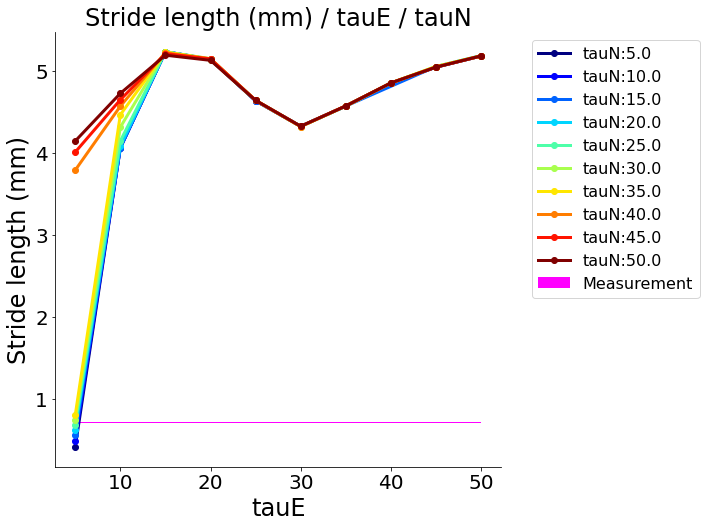

In [9]:
# Stride length / tau

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

# values extracted:
# Stride length: stride_length_all_median (100,)
# Stride duration: boundary_stride_duration_all (100,12)
# Intersegmental delay: boundary_motion_delay_all (100,11)
# Speed: speed_all (100,12)
# Max length: max_len_all (100,11)
# Min length: min_len_all (100,11)
# Contraction duration: contraction_duration_all (100,11)

#kinematics data:
#Stride duration: 1.055±0.013 sec
#Stride length: 0.715±0.006 mm
#Intersegmental delay: 0.100±0.004 sec
#Speed: 0.678±0.010 mm/sec
#Maximum segment length: 0.41±0.006 mm
#Minimum segment length: min_len_all:0.21±0.003 mm
#Contraction duration: 0.435±0.006 sec

Exp_Stride_duration_mean = 1.055
Exp_Stride_duration_sem = 0.013
Exp_Stride_length_mean = 0.715
Exp_Stride_length_sem = 0.006
Exp_Intersegmental_delay_mean = 0.100
Exp_Intersegmental_delay_sem = 0.004
Exp_Speed_mean = 0.678
Exp_Speed_sem = 0.010
Exp_Max_seg_length_mean = 0.41
Exp_Max_seg_length_sem = 0.006
Exp_Min_seg_length_mean = 0.21
Exp_Min_seg_length_sem = 0.003
Exp_Contraction_duration_mean = 0.435
Exp_Contraction_duration_sem = 0.006

extracted_dat_all = stride_length_all_median
v_mean = Exp_Stride_length_mean
v_sem = Exp_Stride_length_sem
value_name = "Stride length (mm)"
# Exp_Stride_length, Exp_Intersegmental_delay, Exp_Speed, 
# Exp_Max_seg_length, Exp_Min_seg_length, Exp_Contraction_duration

v_min = v_mean - v_sem
v_max = v_mean + v_sem

x_min, x_max = param0_range.min(), param0_range.max()



import matplotlib.patches as patches
import matplotlib.pyplot as plt

param1_num = len(file_id_matrix)
cm_name = "jet"
cm = plt.get_cmap(cm_name, param1_num)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

for id1 in range(len(file_id_matrix)):
    X,Y = [],[]
    for file_id in file_id_matrix[id1]:
        X.append(params_all[file_id][param0_id])
        Y.append(extracted_dat_all[file_id])
    ax.plot(X, Y, linewidth=3, color=cm(id1), marker="o", label="{0}:{1}".format(param_id_EE[param1_id],params_all[file_id][param1_id]))

ax.add_patch(patches.Rectangle((x_min,v_min), x_max-x_min, v_max-v_min, alpha=1, facecolor="#ff00ff", fill=True, label="Measurement"))

plt.xlabel(param_id_EE[param0_id], fontsize=24)
plt.ylabel(value_name, fontsize=24)

#plt.xlim([0,13])
#plt.ylim([-0.01,1.1])
#plt.xticks(np.arange(1,13))
#plt.yticks([0,0.5,1])
plt.tick_params(labelsize=20)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("{0} / {1} / {2}".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), fontsize = 24)
plt.savefig(img_path + "Perturbation_201211_{0}_{1}_{2}.png".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), 
            facecolor="white", bbox_inches = "tight")
plt.show()

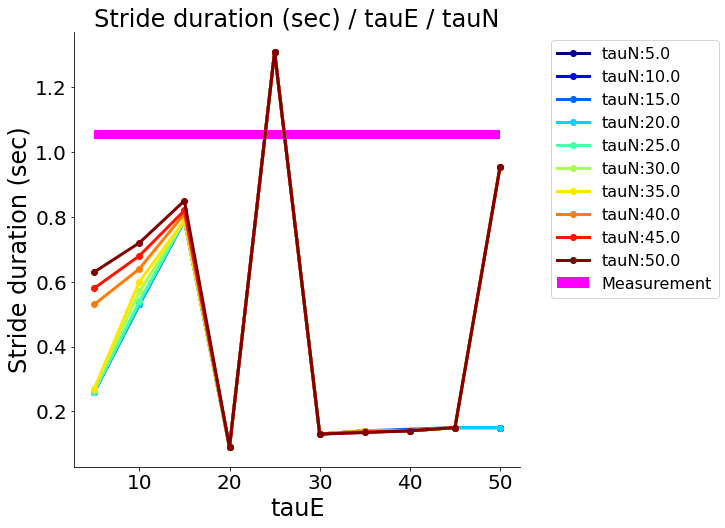

In [10]:
# Stride duration / tau

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

# values extracted:
# Stride length: stride_length_all_median (100,)
# Stride duration: boundary_stride_duration_all (100,12)
# Intersegmental delay: boundary_motion_delay_all (100,11)
# Speed: speed_all (100,12)
# Max length: max_len_all (100,11)
# Min length: min_len_all (100,11)
# Contraction duration: contraction_duration_all (100,11)

#kinematics data:
#Stride duration: 1.055±0.013 sec
#Stride length: 0.715±0.006 mm
#Intersegmental delay: 0.100±0.004 sec
#Speed: 0.678±0.010 mm/sec
#Maximum segment length: 0.41±0.006 mm
#Minimum segment length: min_len_all:0.21±0.003 mm
#Contraction duration: 0.435±0.006 sec

Exp_Stride_duration_mean = 1.055
Exp_Stride_duration_sem = 0.013
Exp_Stride_length_mean = 0.715
Exp_Stride_length_sem = 0.006
Exp_Intersegmental_delay_mean = 0.100
Exp_Intersegmental_delay_sem = 0.004
Exp_Speed_mean = 0.678
Exp_Speed_sem = 0.010
Exp_Max_seg_length_mean = 0.41
Exp_Max_seg_length_sem = 0.006
Exp_Min_seg_length_mean = 0.21
Exp_Min_seg_length_sem = 0.003
Exp_Contraction_duration_mean = 0.435
Exp_Contraction_duration_sem = 0.006

src_dat = boundary_stride_duration_all
extracted_dat_all = []
for file_id in range(len(src_dat)):
    extracted_dat_all.append(np.median(src_dat[file_id]))
extracted_dat_all = np.array(extracted_dat_all)
    
v_mean = Exp_Stride_duration_mean
v_sem = Exp_Stride_duration_sem
value_name = "Stride duration (sec)"
# Exp_Stride_duration, Exp_Stride_length, Exp_Intersegmental_delay, Exp_Speed, 
# Exp_Max_seg_length, Exp_Min_seg_length, Exp_Contraction_duration

v_min = v_mean - v_sem
v_max = v_mean + v_sem

x_min, x_max = param0_range.min(), param0_range.max()


import matplotlib.patches as patches
import matplotlib.pyplot as plt

param1_num = len(file_id_matrix)
cm_name = "jet"
cm = plt.get_cmap(cm_name, param1_num)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

for id1 in range(len(file_id_matrix)):
    X,Y = [],[]
    for file_id in file_id_matrix[id1]:
        X.append(params_all[file_id][param0_id])
        Y.append(extracted_dat_all[file_id])
    ax.plot(X, Y, linewidth=3, color=cm(id1), marker="o", label="{0}:{1}".format(param_id_EE[param1_id],params_all[file_id][param1_id]))

ax.add_patch(patches.Rectangle((x_min,v_min), x_max-x_min, v_max-v_min, alpha=1, facecolor="#ff00ff", fill=True, label="Measurement"))

plt.xlabel(param_id_EE[param0_id], fontsize=24)
plt.ylabel(value_name, fontsize=24)

#plt.xlim([0,13])
#plt.ylim([-0.01,1.1])
#plt.xticks(np.arange(1,13))
#plt.yticks([0,0.5,1])
plt.tick_params(labelsize=20)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("{0} / {1} / {2}".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), fontsize = 24)
plt.savefig(img_path + "Perturbation_201211_{0}_{1}_{2}.png".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), 
            facecolor="white", bbox_inches = "tight")
plt.show()

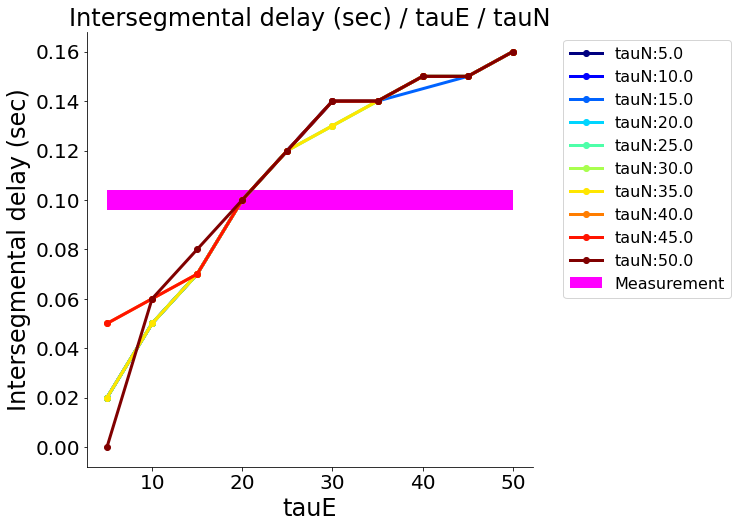

In [11]:
# Intersegmental delay / tau

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

# values extracted:
# Stride length: stride_length_all_median (100,)
# Stride duration: boundary_stride_duration_all (100,12)
# Intersegmental delay: boundary_motion_delay_all (100,11)
# Speed: speed_all (100,12)
# Max length: max_len_all (100,11)
# Min length: min_len_all (100,11)
# Contraction duration: contraction_duration_all (100,11)

#kinematics data:
#Stride duration: 1.055±0.013 sec
#Stride length: 0.715±0.006 mm
#Intersegmental delay: 0.100±0.004 sec
#Speed: 0.678±0.010 mm/sec
#Maximum segment length: 0.41±0.006 mm
#Minimum segment length: min_len_all:0.21±0.003 mm
#Contraction duration: 0.435±0.006 sec

Exp_Stride_duration_mean = 1.055
Exp_Stride_duration_sem = 0.013
Exp_Stride_length_mean = 0.715
Exp_Stride_length_sem = 0.006
Exp_Intersegmental_delay_mean = 0.100
Exp_Intersegmental_delay_sem = 0.004
Exp_Speed_mean = 0.678
Exp_Speed_sem = 0.010
Exp_Max_seg_length_mean = 0.41
Exp_Max_seg_length_sem = 0.006
Exp_Min_seg_length_mean = 0.21
Exp_Min_seg_length_sem = 0.003
Exp_Contraction_duration_mean = 0.435
Exp_Contraction_duration_sem = 0.006

src_dat = boundary_motion_delay_all
extracted_dat_all = []
for file_id in range(len(src_dat)):
    extracted_dat_all.append(np.median(src_dat[file_id]))
extracted_dat_all = np.array(extracted_dat_all)
    
v_mean = Exp_Intersegmental_delay_mean
v_sem = Exp_Intersegmental_delay_sem
value_name = "Intersegmental delay (sec)"
# Exp_Stride_duration, Exp_Stride_length, Exp_Intersegmental_delay, Exp_Speed, 
# Exp_Max_seg_length, Exp_Min_seg_length, Exp_Contraction_duration

v_min = v_mean - v_sem
v_max = v_mean + v_sem

x_min, x_max = param0_range.min(), param0_range.max()

import matplotlib.patches as patches
import matplotlib.pyplot as plt

param1_num = len(file_id_matrix)
cm_name = "jet"
cm = plt.get_cmap(cm_name, param1_num)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

for id1 in range(len(file_id_matrix)):
    X,Y = [],[]
    for file_id in file_id_matrix[id1]:
        X.append(params_all[file_id][param0_id])
        Y.append(extracted_dat_all[file_id])
    ax.plot(X, Y, linewidth=3, color=cm(id1), marker="o", label="{0}:{1}".format(param_id_EE[param1_id],params_all[file_id][param1_id]))

ax.add_patch(patches.Rectangle((x_min,v_min), x_max-x_min, v_max-v_min, alpha=1, facecolor="#ff00ff", fill=True, label="Measurement"))

plt.xlabel(param_id_EE[param0_id], fontsize=24)
plt.ylabel(value_name, fontsize=24)

#plt.xlim([0,13])
#plt.ylim([-0.01,1.1])
#plt.xticks(np.arange(1,13))
#plt.yticks([0,0.5,1])
plt.tick_params(labelsize=20)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("{0} / {1} / {2}".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), fontsize = 24)
plt.savefig(img_path + "Perturbation_201211_{0}_{1}_{2}.png".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), 
            facecolor="white", bbox_inches = "tight")
plt.show()

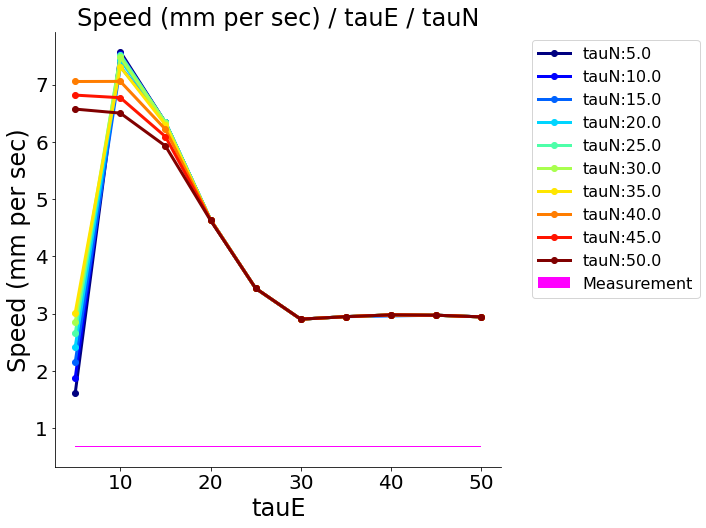

In [12]:
# Intersegmental delay / tau

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

# values extracted:
# Stride length: stride_length_all_median (100,)
# Stride duration: boundary_stride_duration_all (100,12)
# Intersegmental delay: boundary_motion_delay_all (100,11)
# Speed: speed_all (100,12)
# Max length: max_len_all (100,11)
# Min length: min_len_all (100,11)
# Contraction duration: contraction_duration_all (100,11)

#kinematics data:
#Stride duration: 1.055±0.013 sec
#Stride length: 0.715±0.006 mm
#Intersegmental delay: 0.100±0.004 sec
#Speed: 0.678±0.010 mm/sec
#Maximum segment length: 0.41±0.006 mm
#Minimum segment length: min_len_all:0.21±0.003 mm
#Contraction duration: 0.435±0.006 sec

Exp_Stride_duration_mean = 1.055
Exp_Stride_duration_sem = 0.013
Exp_Stride_length_mean = 0.715
Exp_Stride_length_sem = 0.006
Exp_Intersegmental_delay_mean = 0.100
Exp_Intersegmental_delay_sem = 0.004
Exp_Speed_mean = 0.678
Exp_Speed_sem = 0.010
Exp_Max_seg_length_mean = 0.41
Exp_Max_seg_length_sem = 0.006
Exp_Min_seg_length_mean = 0.21
Exp_Min_seg_length_sem = 0.003
Exp_Contraction_duration_mean = 0.435
Exp_Contraction_duration_sem = 0.006

src_dat = speed_all
extracted_dat_all = []
for file_id in range(len(src_dat)):
    extracted_dat_all.append(np.median(src_dat[file_id]))
extracted_dat_all = np.array(extracted_dat_all)
    
v_mean = Exp_Speed_mean
v_sem = Exp_Speed_sem
value_name = "Speed (mm per sec)"
# Exp_Stride_duration, Exp_Stride_length, Exp_Intersegmental_delay, Exp_Speed, 
# Exp_Max_seg_length, Exp_Min_seg_length, Exp_Contraction_duration

v_min = v_mean - v_sem
v_max = v_mean + v_sem

x_min, x_max = param0_range.min(), param0_range.max()

import matplotlib.patches as patches
import matplotlib.pyplot as plt

param1_num = len(file_id_matrix)
cm_name = "jet"
cm = plt.get_cmap(cm_name, param1_num)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

for id1 in range(len(file_id_matrix)):
    X,Y = [],[]
    for file_id in file_id_matrix[id1]:
        X.append(params_all[file_id][param0_id])
        Y.append(extracted_dat_all[file_id])
    ax.plot(X, Y, linewidth=3, color=cm(id1), marker="o", label="{0}:{1}".format(param_id_EE[param1_id],params_all[file_id][param1_id]))

ax.add_patch(patches.Rectangle((x_min,v_min), x_max-x_min, v_max-v_min, alpha=1, facecolor="#ff00ff", fill=True, label="Measurement"))

plt.xlabel(param_id_EE[param0_id], fontsize=24)
plt.ylabel(value_name, fontsize=24)

#plt.xlim([0,13])
#plt.ylim([-0.01,1.1])
#plt.xticks(np.arange(1,13))
#plt.yticks([0,0.5,1])
plt.tick_params(labelsize=20)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("{0} / {1} / {2}".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), fontsize = 24)
plt.savefig(img_path + "Perturbation_201211_{0}_{1}_{2}.png".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), 
            facecolor="white", bbox_inches = "tight")
plt.show()

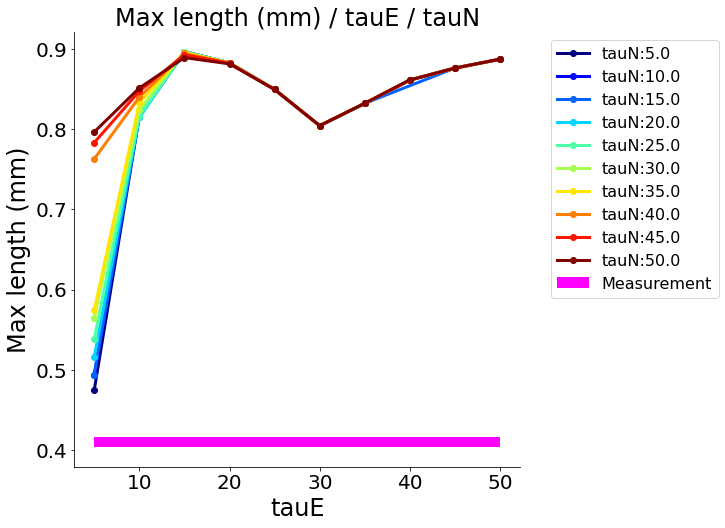

In [13]:
# Intersegmental delay / tau

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

# values extracted:
# Stride length: stride_length_all_median (100,)
# Stride duration: boundary_stride_duration_all (100,12)
# Intersegmental delay: boundary_motion_delay_all (100,11)
# Speed: speed_all (100,12)
# Max length: max_len_all (100,11)
# Min length: min_len_all (100,11)
# Contraction duration: contraction_duration_all (100,11)

#kinematics data:
#Stride duration: 1.055±0.013 sec
#Stride length: 0.715±0.006 mm
#Intersegmental delay: 0.100±0.004 sec
#Speed: 0.678±0.010 mm/sec
#Maximum segment length: 0.41±0.006 mm
#Minimum segment length: min_len_all:0.21±0.003 mm
#Contraction duration: 0.435±0.006 sec

Exp_Stride_duration_mean = 1.055
Exp_Stride_duration_sem = 0.013
Exp_Stride_length_mean = 0.715
Exp_Stride_length_sem = 0.006
Exp_Intersegmental_delay_mean = 0.100
Exp_Intersegmental_delay_sem = 0.004
Exp_Speed_mean = 0.678
Exp_Speed_sem = 0.010
Exp_Max_seg_length_mean = 0.41
Exp_Max_seg_length_sem = 0.006
Exp_Min_seg_length_mean = 0.21
Exp_Min_seg_length_sem = 0.003
Exp_Contraction_duration_mean = 0.435
Exp_Contraction_duration_sem = 0.006

src_dat = max_len_all
extracted_dat_all = []
for file_id in range(len(src_dat)):
    extracted_dat_all.append(np.median(src_dat[file_id]))
extracted_dat_all = np.array(extracted_dat_all)
    
v_mean = Exp_Max_seg_length_mean
v_sem = Exp_Max_seg_length_sem
value_name = "Max length (mm)"
# Exp_Stride_duration, Exp_Stride_length, Exp_Intersegmental_delay, Exp_Speed, 
# Exp_Max_seg_length, Exp_Min_seg_length, Exp_Contraction_duration

v_min = v_mean - v_sem
v_max = v_mean + v_sem

x_min, x_max = param0_range.min(), param0_range.max()

import matplotlib.patches as patches
import matplotlib.pyplot as plt

param1_num = len(file_id_matrix)
cm_name = "jet"
cm = plt.get_cmap(cm_name, param1_num)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

for id1 in range(len(file_id_matrix)):
    X,Y = [],[]
    for file_id in file_id_matrix[id1]:
        X.append(params_all[file_id][param0_id])
        Y.append(extracted_dat_all[file_id])
    ax.plot(X, Y, linewidth=3, color=cm(id1), marker="o", label="{0}:{1}".format(param_id_EE[param1_id],params_all[file_id][param1_id]))

ax.add_patch(patches.Rectangle((x_min,v_min), x_max-x_min, v_max-v_min, alpha=1, facecolor="#ff00ff", fill=True, label="Measurement"))

plt.xlabel(param_id_EE[param0_id], fontsize=24)
plt.ylabel(value_name, fontsize=24)

#plt.xlim([0,13])
#plt.ylim([-0.01,1.1])
#plt.xticks(np.arange(1,13))
#plt.yticks([0,0.5,1])
plt.tick_params(labelsize=20)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("{0} / {1} / {2}".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), fontsize = 24)
plt.savefig(img_path + "Perturbation_201211_{0}_{1}_{2}.png".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), 
            facecolor="white", bbox_inches = "tight")
plt.show()

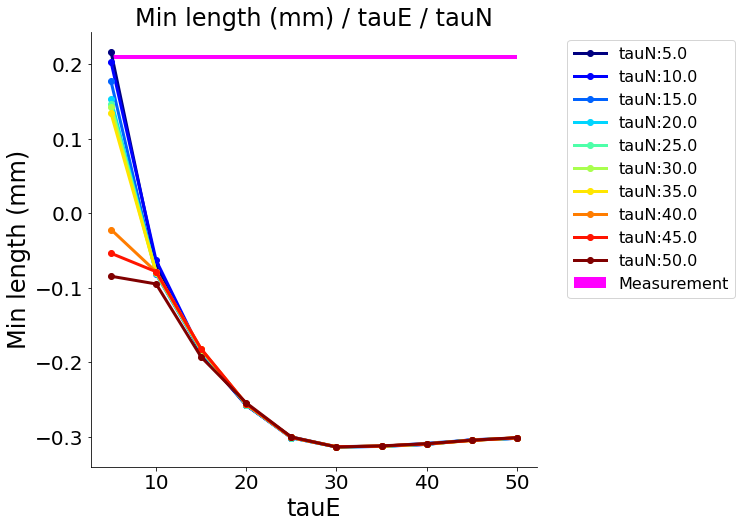

In [14]:
# Intersegmental delay / tau

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

# values extracted:
# Stride length: stride_length_all_median (100,)
# Stride duration: boundary_stride_duration_all (100,12)
# Intersegmental delay: boundary_motion_delay_all (100,11)
# Speed: speed_all (100,12)
# Max length: max_len_all (100,11)
# Min length: min_len_all (100,11)
# Contraction duration: contraction_duration_all (100,11)

#kinematics data:
#Stride duration: 1.055±0.013 sec
#Stride length: 0.715±0.006 mm
#Intersegmental delay: 0.100±0.004 sec
#Speed: 0.678±0.010 mm/sec
#Maximum segment length: 0.41±0.006 mm
#Minimum segment length: min_len_all:0.21±0.003 mm
#Contraction duration: 0.435±0.006 sec

Exp_Stride_duration_mean = 1.055
Exp_Stride_duration_sem = 0.013
Exp_Stride_length_mean = 0.715
Exp_Stride_length_sem = 0.006
Exp_Intersegmental_delay_mean = 0.100
Exp_Intersegmental_delay_sem = 0.004
Exp_Speed_mean = 0.678
Exp_Speed_sem = 0.010
Exp_Max_seg_length_mean = 0.41
Exp_Max_seg_length_sem = 0.006
Exp_Min_seg_length_mean = 0.21
Exp_Min_seg_length_sem = 0.003
Exp_Contraction_duration_mean = 0.435
Exp_Contraction_duration_sem = 0.006

src_dat = min_len_all
extracted_dat_all = []
for file_id in range(len(src_dat)):
    extracted_dat_all.append(np.median(src_dat[file_id]))
extracted_dat_all = np.array(extracted_dat_all)
    
v_mean = Exp_Min_seg_length_mean
v_sem = Exp_Min_seg_length_sem
value_name = "Min length (mm)"
# Exp_Stride_duration, Exp_Stride_length, Exp_Intersegmental_delay, Exp_Speed, 
# Exp_Max_seg_length, Exp_Min_seg_length, Exp_Contraction_duration

v_min = v_mean - v_sem
v_max = v_mean + v_sem

x_min, x_max = param0_range.min(), param0_range.max()

import matplotlib.patches as patches
import matplotlib.pyplot as plt

param1_num = len(file_id_matrix)
cm_name = "jet"
cm = plt.get_cmap(cm_name, param1_num)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

for id1 in range(len(file_id_matrix)):
    X,Y = [],[]
    for file_id in file_id_matrix[id1]:
        X.append(params_all[file_id][param0_id])
        Y.append(extracted_dat_all[file_id])
    ax.plot(X, Y, linewidth=3, color=cm(id1), marker="o", label="{0}:{1}".format(param_id_EE[param1_id],params_all[file_id][param1_id]))

ax.add_patch(patches.Rectangle((x_min,v_min), x_max-x_min, v_max-v_min, alpha=1, facecolor="#ff00ff", fill=True, label="Measurement"))

plt.xlabel(param_id_EE[param0_id], fontsize=24)
plt.ylabel(value_name, fontsize=24)

#plt.xlim([0,13])
#plt.ylim([-0.01,1.1])
#plt.xticks(np.arange(1,13))
#plt.yticks([0,0.5,1])
plt.tick_params(labelsize=20)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("{0} / {1} / {2}".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), fontsize = 24)
plt.savefig(img_path + "Perturbation_201211_{0}_{1}_{2}.png".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), 
            facecolor="white", bbox_inches = "tight")
plt.show()

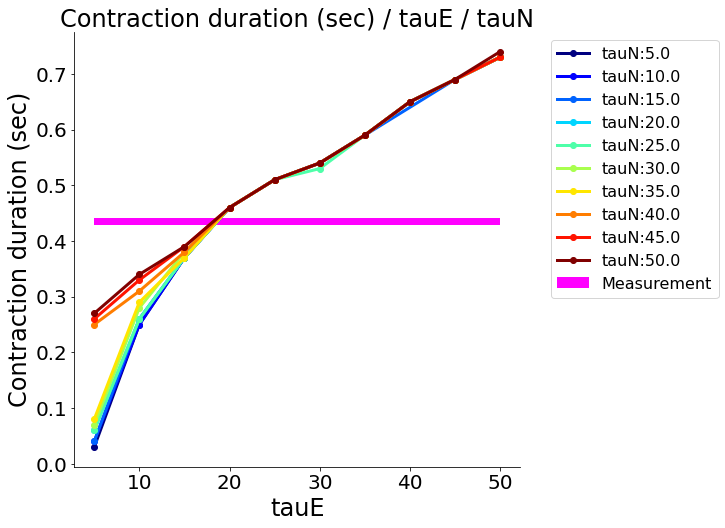

In [15]:
# Intersegmental delay / tau

# index(14), theta_E:0.6
# index(15), tauE:10.0
# index(16), theta_N:0.6
# index(17), tauN:10.0
# index(18), theta_t:0.2
# index(19), taut:150.0
# index(20), theta_S:0.8
# param_id_EE, param_id_EI
# param_id_EE, param_id_EI

param0_id = 15
param1_id = 17

# values extracted:
# Stride length: stride_length_all_median (100,)
# Stride duration: boundary_stride_duration_all (100,12)
# Intersegmental delay: boundary_motion_delay_all (100,11)
# Speed: speed_all (100,12)
# Max length: max_len_all (100,11)
# Min length: min_len_all (100,11)
# Contraction duration: contraction_duration_all (100,11)

#kinematics data:
#Stride duration: 1.055±0.013 sec
#Stride length: 0.715±0.006 mm
#Intersegmental delay: 0.100±0.004 sec
#Speed: 0.678±0.010 mm/sec
#Maximum segment length: 0.41±0.006 mm
#Minimum segment length: min_len_all:0.21±0.003 mm
#Contraction duration: 0.435±0.006 sec

Exp_Stride_duration_mean = 1.055
Exp_Stride_duration_sem = 0.013
Exp_Stride_length_mean = 0.715
Exp_Stride_length_sem = 0.006
Exp_Intersegmental_delay_mean = 0.100
Exp_Intersegmental_delay_sem = 0.004
Exp_Speed_mean = 0.678
Exp_Speed_sem = 0.010
Exp_Max_seg_length_mean = 0.41
Exp_Max_seg_length_sem = 0.006
Exp_Min_seg_length_mean = 0.21
Exp_Min_seg_length_sem = 0.003
Exp_Contraction_duration_mean = 0.435
Exp_Contraction_duration_sem = 0.006

src_dat = contraction_duration_all
extracted_dat_all = []
for file_id in range(len(src_dat)):
    extracted_dat_all.append(np.median(src_dat[file_id]))
extracted_dat_all = np.array(extracted_dat_all)
    
v_mean = Exp_Contraction_duration_mean
v_sem = Exp_Contraction_duration_sem
value_name = "Contraction duration (sec)"
# Exp_Stride_duration, Exp_Stride_length, Exp_Intersegmental_delay, Exp_Speed, 
# Exp_Max_seg_length, Exp_Min_seg_length, Exp_Contraction_duration

v_min = v_mean - v_sem
v_max = v_mean + v_sem

x_min, x_max = param0_range.min(), param0_range.max()


import matplotlib.patches as patches
import matplotlib.pyplot as plt

param1_num = len(file_id_matrix)
cm_name = "jet"
cm = plt.get_cmap(cm_name, param1_num)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

for id1 in range(len(file_id_matrix)):
    X,Y = [],[]
    for file_id in file_id_matrix[id1]:
        X.append(params_all[file_id][param0_id])
        Y.append(extracted_dat_all[file_id])
    ax.plot(X, Y, linewidth=3, color=cm(id1), marker="o", label="{0}:{1}".format(param_id_EE[param1_id],params_all[file_id][param1_id]))

ax.add_patch(patches.Rectangle((x_min,v_min), x_max-x_min, v_max-v_min, alpha=1, facecolor="#ff00ff", fill=True, label="Measurement"))

plt.xlabel(param_id_EE[param0_id], fontsize=24)
plt.ylabel(value_name, fontsize=24)

#plt.xlim([0,13])
#plt.ylim([-0.01,1.1])
#plt.xticks(np.arange(1,13))
#plt.yticks([0,0.5,1])
plt.tick_params(labelsize=20)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("{0} / {1} / {2}".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), fontsize = 24)
plt.savefig(img_path + "Perturbation_201211_{0}_{1}_{2}.png".format(value_name, param_id_EE[param0_id], param_id_EE[param1_id]), 
            facecolor="white", bbox_inches = "tight")
plt.show()

### Stride length

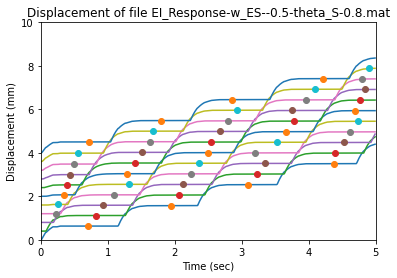

In [9]:
import peakutils
from scipy.signal import argrelmax

xmin = 0
xmax = 10
bins = 200
width = (xmax-xmin)/bins

stride_all = []

for file_id in range(len(disp_abs_all)):
    stride_seg = []
    for seg in range(len(disp_abs_all[0])):
        stride_seg0 = []
        hist_dat = np.histogram(disp_abs_all[file_id][seg,:,1], bins=bins, range=(xmin,xmax))
        #peaks = hist_dat[1][argrelmax(hist_dat[0], order=4)]
        peaks_id = peakutils.indexes(hist_dat[0], thres=0.2, min_dist=5)
        peaks_id = np.sort(peaks_id)
        peaks = hist_dat[1][peaks_id]
        for peak_id in range(len(peaks)):
            dat0 = disp_abs_all[file_id][seg]
            disp_peak = [dat0[i,1] for i in range(len(dat0)) 
                         if dat0[i,1] > peaks[peak_id] and dat0[i,1] < peaks[peak_id] + width]
            time_peak = [dat0[i,0] for i in range(len(dat0)) 
                         if dat0[i,1] > peaks[peak_id] and dat0[i,1] < peaks[peak_id] + width]
            disp_peak_med = np.median(disp_peak)
            time_peak_med = np.median(time_peak)
            stride_seg0.append([time_peak_med, disp_peak_med])
        stride_seg.append(np.array(stride_seg0))

    stride_all.append(stride_seg)

    plt.figure()
    for seg in range(11):
        plt.plot(disp_abs_all[file_id][seg,:,0], disp_abs_all[file_id][seg,:,1])
        plt.plot(stride_all[file_id][seg][:,0], stride_all[file_id][seg][:,1], 'o')

    plt.title("Displacement of file {0}".format(src_name_list[file_id]))
    plt.xlabel("Time (sec)")
    plt.ylabel("Displacement (mm)")
    plt.xlim([0,5])
    plt.ylim([0,10])
    plt.xticks([0,1,2,3,4,5])
    plt.show()

In [10]:
import numpy as np

stride_length_all = []
for file_id in range(len(stride_all)):
    dst1 = []
    for bd in range(len(stride_all[file_id])):
        dat_stride = stride_all[file_id][bd]
        dst0 = []
        for i in range(len(dat_stride)-1):
            dst0.append(dat_stride[i+1,1]-dat_stride[i,1])
        dst1.append(np.median(dst0))
    stride_length_all.append(dst1)

stride_length_all_median = []
for file_id in range(len(stride_length_all)):
    stride_length_all_median.append(np.median(stride_length_all[file_id]))

print("Stride length:")
for file_id in range(len(stride_length_all)):
    print("{0}:  {1:.3f} mm".format(src_name_list[file_id], stride_length_all_median[file_id]))

Stride length:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.964 mm


### Stride duration (and intersegmental delay)

In [11]:
import numpy as np
import peakutils

sec_per_frame = 0.01

# boundary stride duration
boundary_stride_duration_all = []

for file_id in range(len(disp_abs_all)):
    dst0 = []
    for bd in range(len(disp_abs_all[file_id])):

        sig0 = np.diff(disp_abs_all[file_id][bd][:,1])
        sig1 = np.diff(disp_abs_all[file_id][bd][:,1])

        # centralization
        sig0 = sig0 - sig0.mean()
        sig1 = sig1 - sig1.mean()
        corr = np.correlate(sig1, sig0, "full")
        peaks_id = peakutils.indexes(corr[len(corr)-len(sig0):], thres=0.2, min_dist=20)
        estimated_delay = peaks_id[0] * sec_per_frame
        dst0.append(estimated_delay)
        
        #fig, ax = plt.subplots(2,1, figsize = (10,8))
        #ax[0].plot(sig0, label="sig0")
        #ax[0].plot(sig1, label="sig1")
        #ax[0].legend()
        #ax[1].set_ylabel("corr")
        #ax[1].plot(np.arange(len(corr))-len(sig0)+1, corr)
        #ax[1].plot(peaks_id, corr[peaks_id+len(sig0)-1], 'ro')
        #ax[1].set_xlim([0, len(sig1)])
        #plt.show()
        #plt.savefig(fig_path + "201126_boundary_auto_corr_{0}_seg{1}.png".format(src_name[file_id], seg_id))
        #plt.close()
    boundary_stride_duration_all.append(dst0)

# intersegmental delay
boundary_motion_delay_all = []

for file_id in range(len(disp_abs_all)):
    dst0 = []
    for seg in range(len(disp_abs_all[file_id])-1):

        sig0 = np.diff(disp_abs_all[file_id][seg][:,1])
        sig1 = np.diff(disp_abs_all[file_id][seg+1][:,1])

        # centralization
        sig0 = sig0 - sig0.mean()
        sig1 = sig1 - sig1.mean()
        corr = np.correlate(sig1, sig0, "full")
        t_margin = 2
        peaks_id = peakutils.indexes(corr[len(corr)-len(sig0)-t_margin:], thres=0.2, min_dist=20)
        peaks_id = peaks_id - t_margin
        estimated_delay = peaks_id[0] * sec_per_frame
        dst0.append(estimated_delay)
        
        #fig, ax = plt.subplots(2,1, figsize = (10,8))
        #ax[0].plot(sig0, label="sig0")
        #ax[0].plot(sig1, label="sig1")
        #ax[0].legend()
        #ax[1].set_ylabel("corr")
        #ax[1].plot(np.arange(len(corr))-len(sig0)+1, corr)
        #ax[1].plot(peaks_id, corr[peaks_id+len(sig0)-1], 'ro')
        #ax[1].set_xlim([0, len(sig1)])
        #plt.show()
        #plt.savefig(fig_path + "201126_boundary_motion_interseg_corr_{0}_seg{1}.png".format(src_name[file_id], seg_id))
        #plt.close()
    boundary_motion_delay_all.append(dst0)

In [12]:
print("Stride duration:")
for file_id in range(len(boundary_stride_duration_all)):
    print("{0}:  {1:.3f} sec".format(src_name_list[file_id], np.median(boundary_stride_duration_all[file_id]))) 
print("Intersegmental delay:")
for file_id in range(len(boundary_motion_delay_all)):
    print("{0}:  {1:.3f} sec".format(src_name_list[file_id], np.median(boundary_motion_delay_all[file_id])))

Stride duration:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  1.190 sec
Intersegmental delay:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.110 sec


### Speed

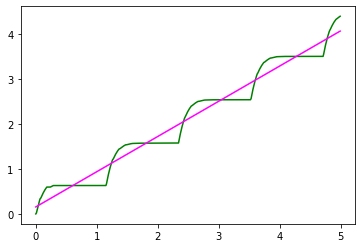

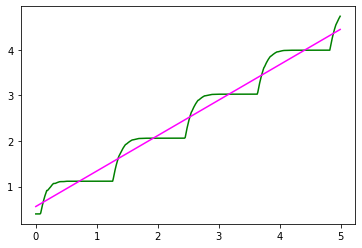

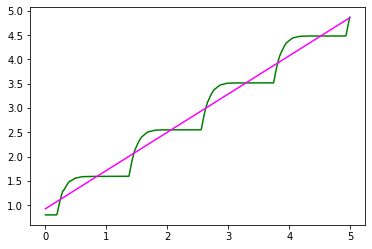

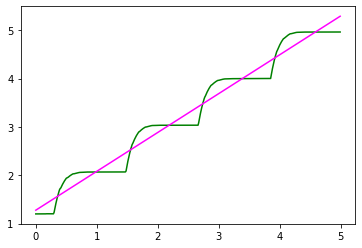

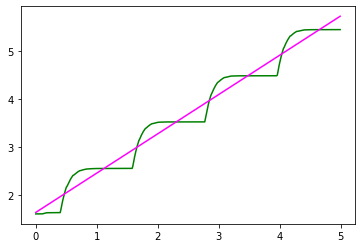

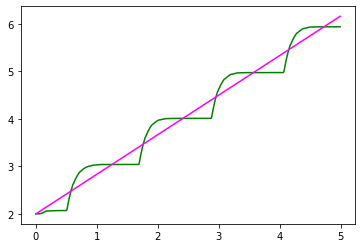

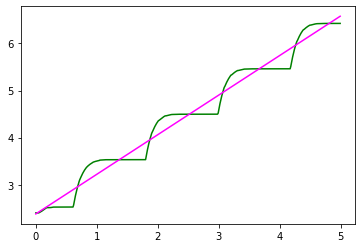

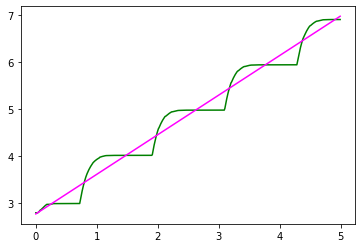

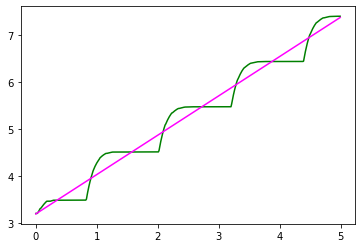

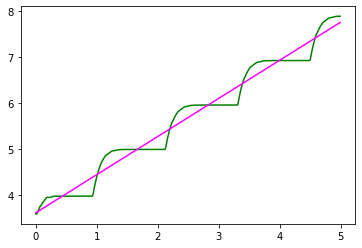

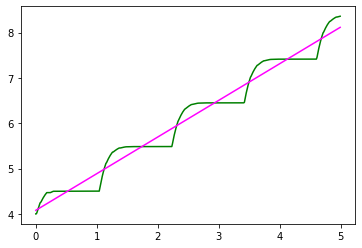

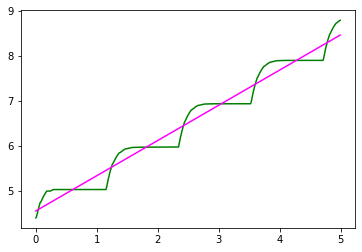

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

speed_all = []

for file_id in range(len(disp_abs_all)):
    dst = []
    for bd in range(len(disp_abs_all[file_id])):
        lr = LinearRegression()
        X = disp_abs_all[file_id][bd,:,0].reshape(-1,1)
        Y = disp_abs_all[file_id][bd,:,1].reshape(-1,1)
        lr.fit(X, Y)

        plt.plot(X, Y, color='green')
        plt.plot(X, lr.predict(X), color='magenta')
        plt.show()
        #plt.savefig(fig_path + "201126_11_points_speed_{0}_seg{1}.png".format(src_name[file_id], seg_id))
        #plt.close()
        dst.append(lr.coef_[0][0])
    speed_all.append(dst)
speed_all = np.array(speed_all)

In [14]:
print("Speed:")
for file_id in range(len(speed_all)):
    print("{0}:  {1:.3f} mm/sec".format(src_name_list[file_id], np.median(speed_all[file_id])))

Speed:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.815 mm/sec


### Max and min segment length

In [15]:
import numpy as np

max_len_all = []
min_len_all = []

for file_id in range(len(seg_len_range_all)):
    dst_max = []
    dst_min = []
    for seg in range(len(seg_len_range_all[file_id])):
        dat = seg_len_range_all[file_id][seg]
        dst_max.append(dat[0][1].max())
        dst_min.append(dat[1][1].min())
    max_len_all.append(dst_max)
    min_len_all.append(dst_min)
max_len_all = np.array(max_len_all)
min_len_all = np.array(min_len_all)

print("Max length:")
for file_id in range(len(max_len_all)):
    print("{0}:  {1:.3f} mm".format(src_name_list[file_id], np.median(max_len_all[file_id])))

print("Min length:")
for file_id in range(len(min_len_all)):
    print("{0}:  {1:.3f} mm".format(src_name_list[file_id], np.median(min_len_all[file_id]))) 

Max length:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.489 mm
Min length:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  -0.093 mm


### Contraction duration

In [16]:
from scipy import signal

FWHM_segment_length_all = []
valley_id = 2   # measure the duration at the valley_id'th valley 

for file_id in range(len(seg_len_all)):
    dst = []
    for seg in range(len(seg_len_all[file_id])):
        dat_time = seg_len_all[file_id][seg][:,0]
        dat_length = seg_len_all[file_id][seg][:,1]
        valley_point = seg_len_range_all[file_id][seg][1][0][valley_id]
        idx = np.where(dat_time == valley_point)[0]
        thrd = (max_len_all[file_id][seg] - min_len_all[file_id][seg])*0.5 + min_len_all[file_id][seg]

        # search for left idx
        left_ = 0
        while(dat_length[idx-left_]<thrd):
            left_ += 1
        idx_left = idx - left_

        # search for right idx
        right_ = 0
        while(dat_length[idx+right_]<thrd):
            right_ += 1
        idx_right = idx + right_

        time_left = dat_time[idx_left]
        time_right = dat_time[idx_right]

        dst0 = [[time_left[0], time_right[0]], [int(idx_left[0]), int(idx_right[0])]]

        dst.append(dst0)
    FWHM_segment_length_all.append(dst)
FWHM_segment_length_all = np.array(FWHM_segment_length_all)

contraction_duration_all = []
for file_id in range(len(FWHM_segment_length_all)):
    dst = []
    for seg in range(len(FWHM_segment_length_all[0])):
        dat = FWHM_segment_length_all[file_id][seg]
        dst.append(dat[0,1] - dat[0,0])
    contraction_duration_all.append(dst)
contraction_duration_all = np.array(contraction_duration_all)

print("Contraction duration:")
for file_id in range(len(contraction_duration_all)):
    print("{0}:  {1:.3f} sec".format(src_name_list[file_id], np.median(contraction_duration_all[file_id]))) 

Contraction duration:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.160 sec


# Summary

In [17]:
print("Stride length:")
for file_id in range(len(stride_length_all)):
    print("{0}:  {1:.3f} mm".format(src_name_list[file_id], stride_length_all_median[file_id]))
print("\n")

print("Stride duration:")
for file_id in range(len(boundary_stride_duration_all)):
    print("{0}:  {1:.3f} sec".format(src_name_list[file_id], np.median(boundary_stride_duration_all[file_id])))
print("\n")

print("Intersegmental delay:")
for file_id in range(len(boundary_motion_delay_all)):
    print("{0}:  {1:.3f} sec".format(src_name_list[file_id], np.median(boundary_motion_delay_all[file_id])))
print("\n")
    
print("Speed:")
for file_id in range(len(speed_all)):
    print("{0}:  {1:.3f} mm/sec".format(src_name_list[file_id], np.median(speed_all[file_id])))
print("\n")

print("Max length:")
for file_id in range(len(max_len_all)):
    print("{0}:  {1:.3f} mm".format(src_name_list[file_id], np.median(max_len_all[file_id])))
print("\n")

print("Min length:")
for file_id in range(len(min_len_all)):
    print("{0}:  {1:.3f} mm".format(src_name_list[file_id], np.median(min_len_all[file_id]))) 
print("\n")
    
print("Contraction duration:")
for file_id in range(len(contraction_duration_all)):
    print("{0}:  {1:.3f} sec".format(src_name_list[file_id], np.median(contraction_duration_all[file_id]))) 

Stride length:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.964 mm


Stride duration:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  1.190 sec


Intersegmental delay:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.110 sec


Speed:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.815 mm/sec


Max length:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.489 mm


Min length:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  -0.093 mm


Contraction duration:
EI_Response-w_ES--0.5-theta_S-0.8.mat:  0.160 sec
